<a href="https://colab.research.google.com/github/Peksyaji/Kaggle/blob/main/Klasifikasi_Kategori_Berita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time

In [2]:
path = 'https://raw.githubusercontent.com/iwanlaudin0101/teks-klasifikasi-menggunakan-model-lstm/master/Dataset/indosum%20datasets.txt'
df = pd.read_csv(path, delimiter='\t', header=None)
df.columns = ['kategori','sumber','berita']
df.head()

,kategori,sumber,berita
0,teknologi,kumparan,Uber pada hari Jumat mengatakan akan menguak d...
1,teknologi,dailysocial.id,"Menyusul jejak NES Classic Edition , SNES Clas..."
2,teknologi,dailysocial.id,"MDI Ventures , perusahaan modal ventura yang d..."
3,teknologi,kumparan,Mazda masih menutup rapat informasi soal sport...
4,teknologi,dailysocial.id,"Sampai di akhir tahun 2017 ini , frasa “ print..."


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   kategori  10000 non-null  object
 1   sumber    10000 non-null  object
 2   berita    10000 non-null  object
dtypes: object(3)
memory usage: 234.5+ KB


In [4]:
df.drop('sumber', axis=1, inplace=True)

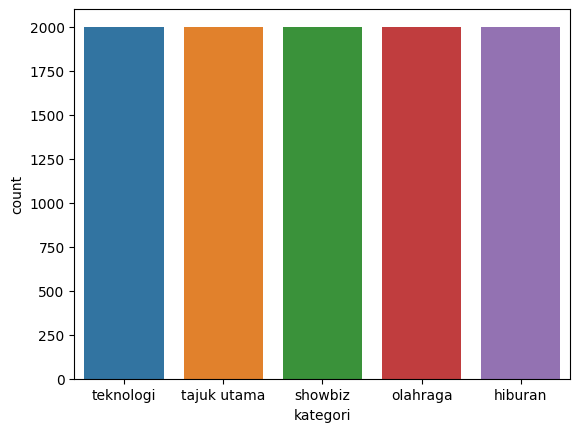

In [5]:
sns.countplot(x=df['kategori'])
plt.show()

In [6]:
df['kategori'].value_counts()

teknologi      2000
tajuk utama    2000
showbiz        2000
olahraga       2000
hiburan        2000
Name: kategori, dtype: int64

# Praproses

In [7]:
!pip install PySastrawi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 kB 7.4 MB/s eta 0:00:00


In [8]:
import re, nltk
import string
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
factory = StopWordRemoverFactory()
stemmer = StemmerFactory().create_stemmer()
Sastrawi_StopWords_id = factory.get_stop_words()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [9]:
def processed_text(text):
    text = text.lower() 
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t]) |(\w+:\/\/\S+)", " ", text).split())
    text = re.sub(r'\@\w+|\#\w+|\d+', '', text)
    punct = str.maketrans('', '', string.punctuation+string.digits)
    text = text.translate(punct)
    # tokenizing words and removing stop words from the news text
    tokens = word_tokenize(text)  
    filtered_words = [w for w in tokens if w not in Sastrawi_StopWords_id]
    # lemmetizing words
    lemmatizer = WordNetLemmatizer() 
    lemma_words = [lemmatizer.lemmatize(w) for w in filtered_words]
    text = " ".join(lemma_words)
    return text

In [10]:
df['clean_teks'] = df['berita'].apply(processed_text)

In [11]:
df.head()

,kategori,berita,clean_teks
0,teknologi,Uber pada hari Jumat mengatakan akan menguak d...,uber jumat menguak data perjalanan paris publi...
1,teknologi,"Menyusul jejak NES Classic Edition , SNES Clas...",menyusul jejak ne classic edition snes classic...
2,teknologi,"MDI Ventures , perusahaan modal ventura yang d...",mdi venture perusahaan modal ventura didukung ...
3,teknologi,Mazda masih menutup rapat informasi soal sport...,mazda menutup rapat informasi sportscar anyar ...
4,teknologi,"Sampai di akhir tahun 2017 ini , frasa “ print...",tahun frasa printer mencetak video terdengar m...


# Feature Engineering

In [12]:
x = df['clean_teks']
y = df['kategori']

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tf_idf = TfidfVectorizer(ngram_range=(1,1))
tf_idf.fit(x)

TfidfVectorizer()

In [14]:
# Melihat Jumlah Fitur
print(len(tf_idf.get_feature_names_out()))

74786


In [15]:
# Melihat fitur-fitur apa saja yang ada di dalam corpus
print(tf_idf.get_feature_names_out())

['aa' 'aaa' 'aaahhhh' ... 'μm' '위잉위' '한가']


In [16]:
X_tf_idf = tf_idf.transform(x).toarray()
X_tf_idf

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

# Feature Selection

In [17]:
data_tf_idf = pd.DataFrame(X_tf_idf, columns=tf_idf.get_feature_names_out())
X = np.array(data_tf_idf)
y = np.array(y)

In [18]:
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2 

# Ten features with highest chi-squared statistics are selected 
chi2_features = SelectKBest(chi2, k=5000) 
X_kbest_features = chi2_features.fit_transform(X, y) 
  
# Reduced features 
print('Original feature number:', X.shape[1]) 
print('Reduced feature number:', X_kbest_features.shape[1])

Original feature number: 74786
Reduced feature number: 5000


In [22]:
from sklearn.model_selection import train_test_split

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X_kbest_features, y, test_size=0.2, random_state=42)

In [24]:
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV

In [25]:
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier

In [34]:
models = {'Multinomial Naive Bayes': MultinomialNB(),
          'Linier SVC': svm.LinearSVC(random_state=42),
          'Random Forest': RandomForestClassifier(random_state=42)
          }

In [35]:
# Validasi silang model
for name, model in models.items():
    start = time()
    model.fit(X_train, y_train)
    train_time = time() - start
    start = time()
    y_pred = model.predict(X_test)
    predict_time = time()-start
    CV = KFold(n_splits = 5, shuffle = True, random_state = 42)
    scores = cross_val_score(model, X_train, y_train, cv = CV)
    print(model)
    print("\tWaktu latih: %0.3fs" % train_time)
    print("\tWaktu prediksi: %0.3fs" % predict_time)
    print('\t5-Fold Validation Scores:', scores)
    print('\tCross Validation Training Accuracy: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

MultinomialNB()
	Waktu latih: 0.327s
	Waktu prediksi: 0.059s
	5-Fold Validation Scores: [0.90625  0.92     0.92     0.906875 0.9125  ]
	Cross Validation Training Accuracy: 0.913 (0.006)
LinearSVC(random_state=42)
	Waktu latih: 0.612s
	Waktu prediksi: 0.046s
	5-Fold Validation Scores: [0.915625 0.9225   0.92125  0.916875 0.9175  ]
	Cross Validation Training Accuracy: 0.919 (0.003)
RandomForestClassifier(random_state=42)
	Waktu latih: 20.233s
	Waktu prediksi: 0.331s
	5-Fold Validation Scores: [0.896875 0.8925   0.916875 0.900625 0.905625]
	Cross Validation Training Accuracy: 0.902 (0.008)


In [32]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [36]:
# Metrik evaluasi
results = dict()
for name, model in models.items():
    model.fit(X_train, y_train)
    predicted = model.predict(X_test)
    print('\nAlgorithm: ', name)
    res_cm = confusion_matrix(y_test, predicted)
    print('Confusion Matrix:\n', res_cm)
    res_acc = accuracy_score(y_test, predicted)
    print('Accuracy: ', res_acc)
    res_pres = precision_score(y_test, predicted, average='micro')
    print('Precision: ', res_pres)
    res_recall = recall_score(y_test, predicted, average='micro')
    print('Recall Score: ', res_recall)
    res_f1 = f1_score(y_test, predicted, average='micro')
    print('F1 Score: ', res_f1)
    
    results[name]=res_acc


Algorithm:  Multinomial Naive Bayes
Confusion Matrix:
 [[290   3  44  36  14]
 [  2 404   1   6   2]
 [ 15   1 367   9   3]
 [ 18   1   5 364   5]
 [  7   0   4   9 390]]
Accuracy:  0.9075
Precision:  0.9075
Recall Score:  0.9075
F1 Score:  0.9075

Algorithm:  Linier SVC
Confusion Matrix:
 [[316   4  30  30   7]
 [  3 405   3   2   2]
 [ 17   1 372   3   2]
 [ 20   2   4 364   3]
 [ 10   0   2   5 393]]
Accuracy:  0.925
Precision:  0.925
Recall Score:  0.925
F1 Score:  0.925

Algorithm:  Random Forest
Confusion Matrix:
 [[299   6  43  35   4]
 [  3 407   1   4   0]
 [ 13   1 372   7   2]
 [ 12   2   4 373   2]
 [ 18   2   4  24 362]]
Accuracy:  0.9065
Precision:  0.9065
Recall Score:  0.9065
F1 Score:  0.9064999999999999
